In [1]:
model_name= 'biobert_lstm_ft_gastric'


%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('../')

import os
import tensorflow 
import numpy as np
import random

seed_value = 42
#seed_value = None

np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

environment_name = sys.executable.split('/')[-3]
print('Environment:', environment_name)
os.environ[environment_name] = str(seed_value)
import torch
if seed_value:
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.compat.v1.keras.backend as K
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)

tensorflow.__version__

Environment: biotmpygpu


'2.2.0'

In [2]:
!timeout 4 nvidia-smi -l 1

Thu Nov 18 18:38:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:89:00.0 Off |                    0 |
| N/A   69C    P0    72W /  70W |  14433MiB / 15109MiB |     66%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:B1:00.0 Off |                    0 |
| N/A   

In [3]:
multiple_gpus = [1,2,3]
#multiple_gpus = None

In [4]:
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if multiple_gpus:
    devices = []
    for gpu in multiple_gpus:
        devices.append('/gpu:' + str(gpu))    
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)
    os.environ["CUDA_VISIBLE_DEVICES"] = ''

else:
    # Get the GPU device name.
    device_name = tensorflow.test.gpu_device_name()
    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

Num GPUs Available:  4
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [5]:
from wrappers.tsv_wrapper import *
from wrappers.pandas_wrapper import relevances_to_pandas, docs_to_pandasdocs
from preprocessing.dl import DL_preprocessing
from mlearning.dl_models import Bert_Dense, Bert_LSTM, Bert_CLS, Bert_Sequence
from preprocessing.dl import Bert_preprocessing
from preprocessing.embeddings import compute_embedding_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from preprocessing.config import Config
from preprocessing.dl import average_precision
from preprocessing.dl import plot_roc_n_pr_curves, plot_training_history
from transformers import BertTokenizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import pandas as pd
import os
from transformers import AutoTokenizer

[nltk_data] Downloading package stopwords to /home/malves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/malves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/malves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/malves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/malves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/malves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
gc_dataset_path = '../datasets/gastric_cancer.tsv'
c_dataset_path = '../datasets/cancer.tsv'
nc_dataset_path = '../datasets/not_cancer.tsv'
output_excel = 'metrics/results_'+ model_name + '.xlsx'

In [7]:
config = Config(model_name=model_name, seed_value=seed_value)

#config.stop_words = set(stopwords.words('english'))            #####
config.stop_words = None
config.lower = False                #####
config.remove_punctuation = False
config.split_by_hyphen = False   
config.lemmatization = False           #####
config.stems = False                       #####


gastric_docs = tsv_to_docs(gc_dataset_path, config=config, sep='\t')
cancer_docs = tsv_to_docs(c_dataset_path, config=config, sep='\t') 
noncancer_docs = tsv_to_docs(nc_dataset_path, config=config, sep='\t') 

gastric_relevances = tsv_to_relevances(gc_dataset_path, 'gastric_cancer')
cancer_relevances = tsv_to_relevances(c_dataset_path, 'cancer')
noncancer_relevances = tsv_to_relevances(nc_dataset_path, 'non_cancer')


#y_train_df = relevances_to_pandas(x_train_df, relevances_train)

In [8]:
gastric_docs[0].id

'pubmed:34461377'

In [9]:
gastric_relevances[0].id

'pubmed:34461377'

In [10]:
gastric_df = docs_to_pandasdocs(gastric_docs)
cancer_df = docs_to_pandasdocs(cancer_docs)
noncancer_df = docs_to_pandasdocs(noncancer_docs)

gastric_df = relevances_to_pandas(gastric_df, gastric_relevances)
cancer_df = relevances_to_pandas(cancer_df,cancer_relevances)
noncancer_df = relevances_to_pandas(noncancer_df, noncancer_relevances)

In [11]:
gastric_df

,Document,Label
pubmed:34461377,<data_structures.document.Document object at 0...,1
pubmed:34461485,<data_structures.document.Document object at 0...,1
pubmed:34461589,<data_structures.document.Document object at 0...,1
pubmed:34461608,<data_structures.document.Document object at 0...,1
pubmed:34461706,<data_structures.document.Document object at 0...,1
...,...,...
pubmed:32724449,<data_structures.document.Document object at 0...,1
pubmed:32724797,<data_structures.document.Document object at 0...,1
pubmed:32724879,<data_structures.document.Document object at 0...,1
pubmed:32724882,<data_structures.document.Document object at 0...,1


In [12]:
print(len(gastric_docs), len(cancer_docs), len(noncancer_docs))

10246 10094 10476


## Gastric Cancer VS Cancer

In [13]:
gc_c = pd.concat([gastric_df, cancer_df]).sample(frac=1, random_state=seed_value)
gc_c

,Document,Label
pubmed:33790057,<data_structures.document.Document object at 0...,1
pubmed:33906525,<data_structures.document.Document object at 0...,1
pubmed:33688258,<data_structures.document.Document object at 0...,1
pubmed:34568058,<data_structures.document.Document object at 0...,0
pubmed:34610313,<data_structures.document.Document object at 0...,0
...,...,...
pubmed:34607550,<data_structures.document.Document object at 0...,0
pubmed:34598020,<data_structures.document.Document object at 0...,0
pubmed:33637371,<data_structures.document.Document object at 0...,1
pubmed:34293086,<data_structures.document.Document object at 0...,1


In [14]:
doc_lens = []
for i, row in gc_c.iterrows():
    d_len = len(row['Document'].fulltext_string)
    doc_lens.append(d_len)


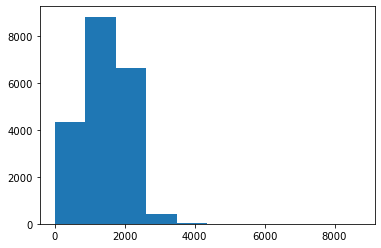

In [15]:
import matplotlib.pyplot as plt 
plt.hist(doc_lens)
plt.show()

In [16]:
#Parameters
config.padding = 'post'           
config.truncating = 'post'        

config.epochs = 3         # recommended number of epochs: 2, 3, 4 
config.batch_size = 16     # recommended batch-size: 16 or 32 
config.learning_rate = 2e-5   # recommended learning rate for Adam: 5e-5, 3e-5, 2e-5   # 3e-4, 1e-4,

config.max_sent_len = 512      #sentences will have a maximum of "max_sent_len" words
config.nmr_sentences = 1      #[1 or 2]

config.validation_percentage = 20

## Preprocessing

## Bert

In [17]:
config.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [18]:
config.tokenizer.convert_tokens_to_ids("[SEP]")

102

In [19]:
x_train, y_train, x_val, y_val =  Bert_preprocessing(gc_c, gc_c['Label'], 
                                                     config, 
                                                     nmr_sentences = config.nmr_sentences, 
                                                     validation_percentage = config.validation_percentage, 
                                                     seed_value=config.seed_value)

Training set with 16272 samples
Validation set with 4068 samples


In [20]:
len(x_train[0][0])

512

In [21]:
config.tokenizer.convert_ids_to_tokens(x_train[0][0])

['[CLS]',
 'long',
 '-',
 'term',
 'efficacy',
 'of',
 's',
 '-',
 '1',
 'mono',
 '##therapy',
 'or',
 'cape',
 '##cit',
 '##abi',
 '##ne',
 'plus',
 'ox',
 '##ali',
 '##pl',
 '##atin',
 'as',
 'ad',
 '##ju',
 '##vant',
 'chemotherapy',
 'for',
 'patients',
 'with',
 'stage',
 'ii',
 'or',
 'iii',
 'gas',
 '##tric',
 'cancer',
 'after',
 'cu',
 '##rative',
 'gas',
 '##tre',
 '##ct',
 '##omy',
 ':',
 'a',
 'prop',
 '##ens',
 '##ity',
 'score',
 '-',
 'matched',
 'multi',
 '##cent',
 '##er',
 'co',
 '##hort',
 'study',
 '.',
 'purpose',
 'to',
 'compare',
 'long',
 '-',
 'term',
 'disease',
 '-',
 'free',
 'survival',
 '(',
 'd',
 '##fs',
 ')',
 'between',
 'patients',
 'receiving',
 'te',
 '##ga',
 '##fur',
 '/',
 'gi',
 '##mer',
 '##ac',
 '##il',
 '/',
 'ot',
 '##era',
 '##ci',
 '##l',
 '(',
 's',
 '-',
 '1',
 ')',
 'or',
 'cape',
 '##cit',
 '##abi',
 '##ne',
 'plus',
 'ox',
 '##ali',
 '##pl',
 '##atin',
 '(',
 'cap',
 '##ox',
 ')',
 'ad',
 '##ju',
 '##vant',
 'chemotherapy',
 '(',
 'a

In [22]:
config.tokenizer.convert_ids_to_tokens(x_val[0][0])

['[CLS]',
 'a',
 'new',
 'player',
 'in',
 'ne',
 '##uro',
 '##bla',
 '##sto',
 '##ma',
 ':',
 'ya',
 '##p',
 'and',
 'its',
 'role',
 'in',
 'the',
 'ne',
 '##uro',
 '##bla',
 '##sto',
 '##ma',
 'micro',
 '##en',
 '##vir',
 '##on',
 '##ment',
 '.',
 'ne',
 '##uro',
 '##bla',
 '##sto',
 '##ma',
 'is',
 'the',
 'most',
 'common',
 'extra',
 '-',
 'cr',
 '##anial',
 'pediatric',
 'solid',
 'tumor',
 'that',
 'accounts',
 'for',
 'more',
 'than',
 '15',
 '%',
 'of',
 'childhood',
 'cancer',
 '-',
 'related',
 'deaths',
 '.',
 'high',
 'risk',
 'ne',
 '##uro',
 '##bla',
 '##sto',
 '##mas',
 'that',
 'rec',
 '##ur',
 'during',
 'or',
 'after',
 'intense',
 'multi',
 '##mo',
 '##dal',
 'therapy',
 'have',
 'a',
 '<',
 '5',
 '%',
 'chance',
 'at',
 'a',
 'second',
 'sustained',
 're',
 '##mission',
 'or',
 'cure',
 '.',
 'the',
 'solid',
 'tumor',
 'micro',
 '##en',
 '##vir',
 '##on',
 '##ment',
 '(',
 't',
 '##me',
 ')',
 'has',
 'been',
 'increasingly',
 'recognized',
 'to',
 'play',
 'a',


## Deep Learning

In [23]:
from mlearning.dl_models import Bert_Dense_opt
bert_name = "bert-base-uncased"
if multiple_gpus:
    with strategy.scope():
        model = Bert_Dense(config, learning_rate=config.learning_rate,static_bert=False, bert_name_or_path=bert_name)
        #model = Bert_FE(config, learning_rate=config.learning_rate, bert_name_or_path=bert_name)
        #model = Bert_Sequence_FT(config, learning_rate=config.learning_rate, bert_name_or_path=bert_name)
        #model = Bert_Sequence_FE(config, learning_rate=config.learning_rate, bert_name_or_path=bert_name)
        
else:
    model = Bert_Dense(config, learning_rate=config.learning_rate, static_bert=False, bert_name_or_path=bert_name)
    #model = Bert_FE(config, learning_rate=config.learning_rate, bert_name_or_path=bert_name)
    #model = Bert_Sequence_FT(config, learning_rate=config.learning_rate, bert_name_or_path=bert_name)
    #model = Bert_Sequence_FE(config, learning_rate=config.learning_rate, bert_name_or_path=bert_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]            

In [24]:
config.keras_callbacks = False

if config.keras_callbacks:
    config.patience = 2   #early-stopping patience
    checkpoint_path = str(config.model_id_path) + '/checkpoint.hdf5'
    keras_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=config.patience),
            ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    ]
else:
    keras_callbacks=None

In [25]:
history = model.fit(x_train, y_train,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=keras_callbacks)

if config.keras_callbacks:
    model.load_weights(checkpoint_path)

Epoch 1/3
INFO:tensorflow:batch_all_reduce: 198 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

## Evaluation

In [26]:
#train_loss, config.train_acc = model.evaluate(x_train, y_train, verbose=0)

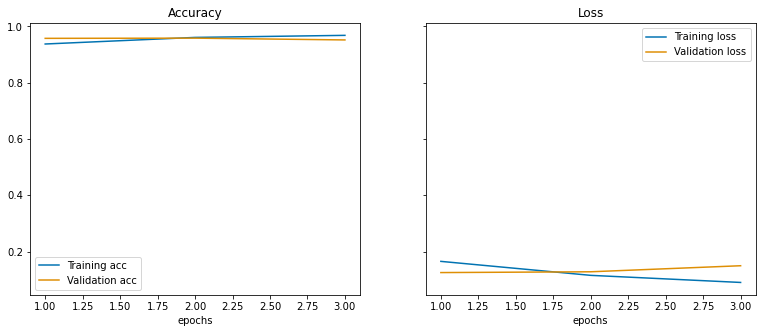

In [27]:
#print('Training Loss: %.3f' % (train_loss))
#print('Training Accuracy: %.3f' % (config.train_acc))


plot_training_history(history_dict = history, config=config)